In [1]:
from os import environ as ENV
DATA = ENV['PWD'] + '/data/'
FIGS = ENV['PWD'] + '/figures/'

In [2]:
import sys
sys.path.append('../src')

from should_be_stdlib import resample_log
from neurodata import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator

In [4]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons].reset_index().drop(columns='index')
coords = get_coords(record).loc[sig_neurons]

In [5]:
# ½ octave with equal temperament (reasonable guess)
old_freqs = resample_log([3,48], 9)
new_freqs = resample_log([3,48], 16)
old_freqs, new_freqs

(array([ 3.        ,  4.24264069,  6.        ,  8.48528137, 12.        ,
        16.97056275, 24.        , 33.9411255 , 48.        ]),
 array([ 3.        ,  3.60907511,  4.34180771,  5.22330338,  6.28376474,
         7.5595263 ,  9.0942994 , 10.94066986, 13.16189976, 15.83409493,
        19.04881262, 22.91619849, 27.56876052, 33.16590912, 39.89941901,
        48.        ]))

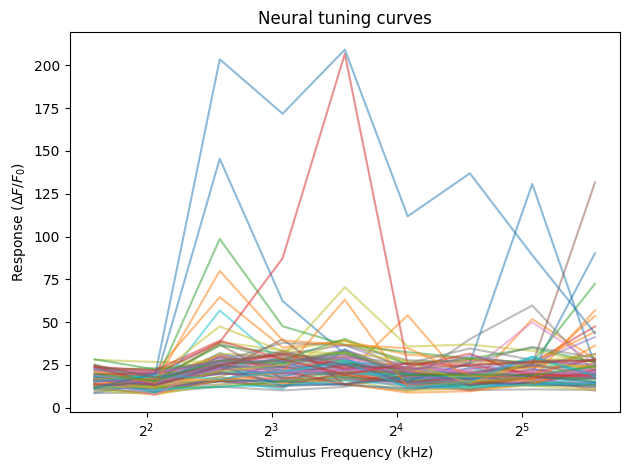

In [6]:
tuning_curves.columns = old_freqs.round(1)
tuning_curves.set_index(sig_neurons, inplace=True)
plt.plot(tuning_curves.T, alpha=0.5)
plt.title('Neural tuning curves')
plt.xlabel('Stimulus Frequency (kHz)')
plt.ylabel('Response ($ΔF/F_0$)')
plt.xscale('log', base=2)
plt.tight_layout()
plt.savefig(FIGS + 'tuning-curves.png', dpi=300)
plt.show()

In [7]:
# rescale tuning curves
def normalize(x, c=1):
    '''Normalize vector and rescale to c'''
    # Multiply then divide for numerical stability
    return x * c / np.linalg.norm(x, ord=1)

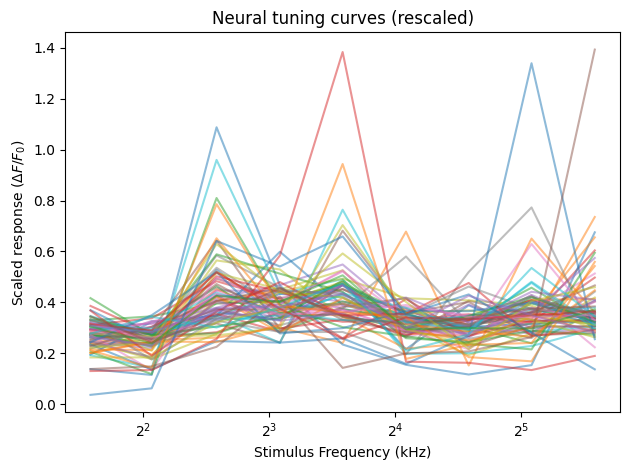

In [8]:
# tuning curves can't be negative. scale to pi so values range from [0, pi]
tuning_curves_rescaled = tuning_curves.apply(
    lambda x: normalize(x, c=np.pi),
    axis = 1,
    result_type = 'expand',
)
tuning_curves_rescaled.to_csv(DATA + 'data_tuning-curves_rescaled.csv')
plt.plot(tuning_curves_rescaled.T, alpha=0.5)
plt.title('Neural tuning curves (rescaled)')
plt.xlabel('Stimulus Frequency (kHz)')
plt.ylabel('Scaled response ($ΔF/F_0$)')
plt.xscale('log', base=2)
plt.tight_layout()
plt.savefig(FIGS + 'tuning-curves-rescaled.png', dpi=300)
plt.show()

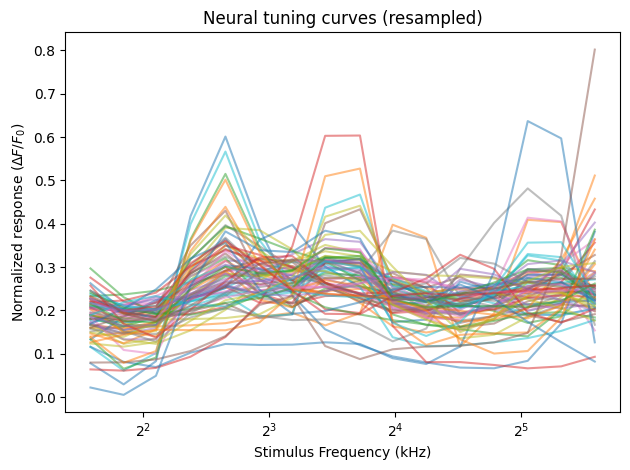

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
23,16.456894,13.386917,14.241179,25.176488,31.539623,24.015185,21.664833,27.733209,26.075725,14.932467,15.453646,23.010958,21.232581,17.190902,18.695779,24.550303
32,19.666185,19.840686,20.087344,20.425779,21.023485,22.783436,23.997637,20.397993,23.889550,49.052892,45.342350,14.347820,23.870124,50.444565,49.809992,28.617633
35,22.065571,22.414608,23.225313,25.095349,26.715004,26.801151,27.604952,30.739339,30.019477,21.070523,19.405530,20.527198,18.803809,16.194653,17.629603,24.291556
36,23.119366,21.303242,20.403798,21.063983,22.841923,26.785243,28.193449,26.116571,25.504507,25.735888,26.462601,27.534032,27.615674,26.254725,31.578954,47.501961
37,16.372349,14.379730,15.591805,24.712940,30.771667,31.016037,29.484790,26.786906,24.524932,22.618538,21.932779,22.156984,24.246946,27.610574,27.655233,24.090648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,21.538996,12.356139,16.589937,56.295555,78.370200,52.218417,38.760202,37.348634,36.384169,35.540715,31.250490,20.809342,15.684859,16.599502,28.642440,56.913355
425,19.843449,16.181614,15.825217,22.940423,27.695072,26.270272,26.970587,31.579390,30.775813,20.828670,19.111818,19.362033,19.292680,19.180220,20.446969,24.119722
426,23.776134,21.381875,22.509381,33.083372,38.698181,32.618289,26.384500,20.595921,20.495882,25.029322,25.641747,25.223822,25.692074,26.361495,26.978724,27.578304
428,21.905144,20.257191,20.319073,24.231985,27.064660,27.054814,27.817609,30.195631,29.694483,22.591060,23.340457,29.967700,28.661748,25.226558,22.574573,20.089453


In [9]:
# upsample the tuning curves to fill the binary space
tuning_curves_resampled = tuning_curves.apply(
    lambda response: Akima1DInterpolator(old_freqs, response, method="makima")(new_freqs),
    axis = 1,
    result_type = 'expand',
)
tuning_curves_resampled.columns = new_freqs.round(1)
tuning_curves_resampled.to_csv(DATA + 'data_tuning-curves_resampled.csv')
plt.plot(tuning_curves_resampled.T.apply(lambda x: x / np.linalg.norm(x)), alpha=0.5)
plt.title('Neural tuning curves (resampled)')
plt.xlabel('Stimulus Frequency (kHz)')
plt.ylabel('Normalized response ($ΔF/F_0$)')
plt.xscale('log', base=2)
plt.tight_layout()
plt.savefig(FIGS + 'tuning-curves-resampled.png', dpi=300)
plt.show()
tuning_curves_resampled